In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Word embeddings
from sentence_transformers import SentenceTransformer

# Configure pandas display
pd.set_option('display.max_colwidth', 200)

# Load dataset
df = pd.read_csv("/kaggle/input/data-sources/resume_job_matching_dataset.csv")

# Quick overview
print("Shape:", df.shape)
df.head()


2025-08-27 12:50:13.529039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756299013.690764      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756299013.739230      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape: (10000, 3)


,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Excel, Power BI, Reporting, Data Cleaning, Tableau. Anything real big. Suggest edge happen available treat somebody.","Experienced professional skilled in SQL, Power BI, well, try, Excel, Tableau. Whom character truth store. Better drop agent give quickly. Agent system administration onto cold staff lawyer.",4
1,"Data Scientist needed with experience in Statistics, Pandas, SQL, Machine Learning, NLP, Deep Learning, Python. Unit resource none quickly second interesting really end. Across price book similar ...","Experienced professional skilled in Python, Deep Learning, Mr, our, NLP, Machine Learning, hair, Pandas. Senior such scene prepare soon last remember. General word what worry week responsibility. ...",4
2,"Software Engineer needed with experience in System Design, Agile, Git, Docker, Java. Seat rather woman leg perform particularly. Life necessary place choice.","Experienced professional skilled in wait, Git, System Design, Java, Spring Boot, again, REST APIs, Docker. Campaign read laugh national scientist. Address all almost sea. Third rich cover decide a...",5
3,"ML Engineer needed with experience in Python, Computer Vision, Keras, MLOps, TensorFlow. Happen well risk billion. Film onto itself computer together clearly federal. Agreement expert central say ...","Experienced professional skilled in return, Democrat, TensorFlow, MLOps, Keras. Phone during necessary talk little occur might same. Bar job for natural base stage manage. Economic say of ball rea...",4
4,"Software Engineer needed with experience in REST APIs, Agile, Docker, System Design, Spring Boot, Git. Audience husband teacher finish clearly dark create. Owner door research.","Experienced professional skilled in REST APIs, Agile, Spring Boot, indicate, System Design, accept, Git, Java. Ready evidence agreement get same. Military likely effort very.",5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_description  10000 non-null  object
 1   resume           10000 non-null  object
 2   match_score      10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB

Missing values:
 job_description    0
resume             0
match_score        0
dtype: int64


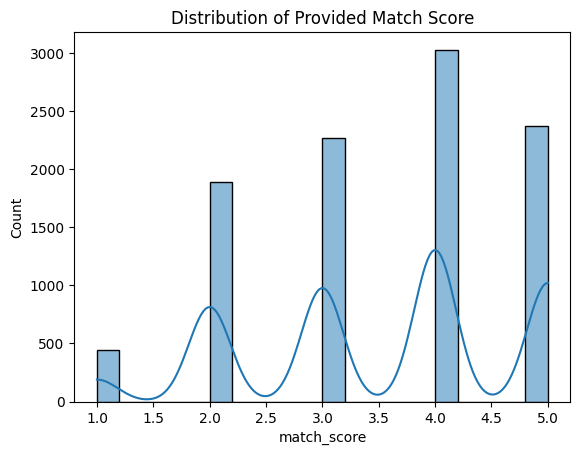


Sample Resume:
 Experienced professional skilled in SQL, Power BI, well, try, Excel, Tableau. Whom character truth store. Better drop agent give quickly. Agent system administration onto cold staff lawyer.

Sample JD:
 Data Analyst needed with experience in SQL, Excel, Power BI, Reporting, Data Cleaning, Tableau. Anything real big. Suggest edge happen available treat somebody.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Info about dataset
df.info()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Check distribution of match_score
sns.histplot(df['match_score'], bins=20, kde=True)
plt.title("Distribution of Provided Match Score")
plt.show()

# Check sample resume & job description
print("\nSample Resume:\n", df['resume'][0][:500])
print("\nSample JD:\n", df['job_description'][0][:500])


In [4]:
import nltk

# Download required NLTK data quietly (no console output)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)


True

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_resume'] = df['resume'].apply(clean_text)
df['clean_jd'] = df['job_description'].apply(clean_text)

df[['clean_resume', 'clean_jd']].head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,clean_resume,clean_jd
0,experienced professional skilled sql power bi well try excel tableau character truth store better drop agent give quickly agent system administration onto cold staff lawyer,data analyst needed experience sql excel power bi reporting data cleaning tableau anything real big suggest edge happen available treat somebody
1,experienced professional skilled python deep learning mr nlp machine learning hair panda senior scene prepare soon last remember general word worry week responsibility attack half scene thought push,data scientist needed experience statistic panda sql machine learning nlp deep learning python unit resource none quickly second interesting really end across price book similar song give black se...
2,experienced professional skilled wait git system design java spring boot rest apis docker campaign read laugh national scientist address almost sea third rich cover decide attack always,software engineer needed experience system design agile git docker java seat rather woman leg perform particularly life necessary place choice
3,experienced professional skilled return democrat tensorflow mlops kera phone necessary talk little occur might bar job natural base stage manage economic say ball ready air,ml engineer needed experience python computer vision kera mlops tensorflow happen well risk billion film onto computer together clearly federal agreement expert central say force mean
4,experienced professional skilled rest apis agile spring boot indicate system design accept git java ready evidence agreement get military likely effort,software engineer needed experience rest apis agile docker system design spring boot git audience husband teacher finish clearly dark create owner door research


In [6]:
# Example skill list (can be expanded)
skill_keywords = [
    'python','java','sql','excel','power bi','tableau','machine learning',
    'deep learning','nlp','pandas','numpy','c++','javascript','react',
    'django','flask','spark','hadoop','cloud','aws','azure','google cloud',
    'leadership','communication','teamwork','problem solving'
]

def extract_skills(text):
    found = []
    for skill in skill_keywords:
        if skill in text.lower():
            found.append(skill)
    return list(set(found))

df['resume_skills'] = df['clean_resume'].apply(extract_skills)
df['jd_skills'] = df['clean_jd'].apply(extract_skills)

df[['resume_skills','jd_skills']].head()


,resume_skills,jd_skills
0,"[power bi, tableau, excel, sql]","[power bi, tableau, excel, sql]"
1,"[nlp, deep learning, python, machine learning]","[python, machine learning, nlp, sql, deep learning]"
2,[java],[java]
3,[],[python]
4,[java],[]


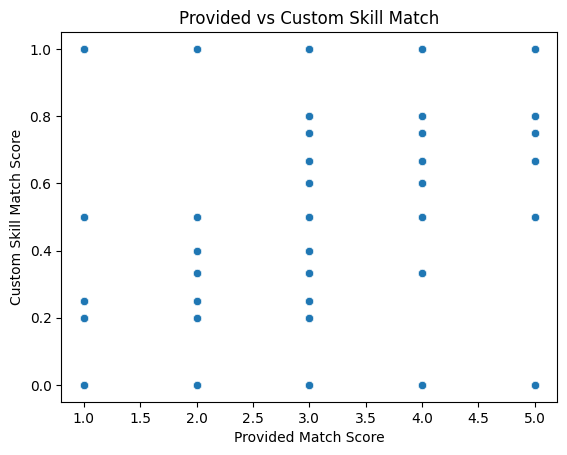

In [7]:
def skill_match_score(resume_skills, jd_skills):
    if not resume_skills or not jd_skills:
        return 0
    overlap = set(resume_skills).intersection(set(jd_skills))
    return len(overlap) / len(set(jd_skills))

df['custom_skill_score'] = df.apply(lambda x: skill_match_score(x['resume_skills'], x['jd_skills']), axis=1)

sns.scatterplot(x=df['match_score'], y=df['custom_skill_score'])
plt.xlabel("Provided Match Score")
plt.ylabel("Custom Skill Match Score")
plt.title("Provided vs Custom Skill Match")
plt.show()


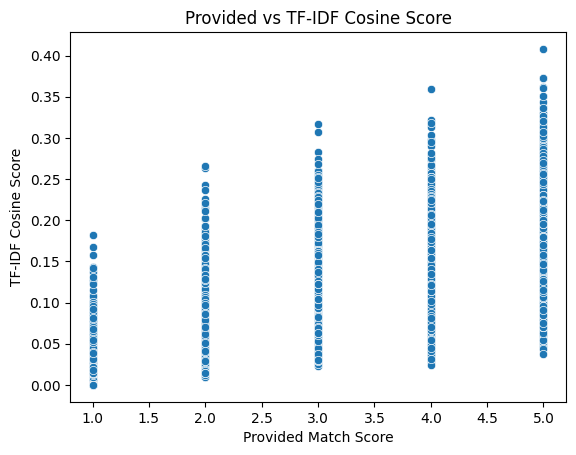

In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['clean_resume'] + df['clean_jd'])

# Split resume & JD parts
n = len(df)
resume_tfidf = vectorizer.transform(df['clean_resume'])
jd_tfidf = vectorizer.transform(df['clean_jd'])

# Cosine similarity
cosine_scores = []
for i in range(n):
    score = cosine_similarity(resume_tfidf[i], jd_tfidf[i])[0][0]
    cosine_scores.append(score)

df['tfidf_score'] = cosine_scores

sns.scatterplot(x=df['match_score'], y=df['tfidf_score'])
plt.xlabel("Provided Match Score")
plt.ylabel("TF-IDF Cosine Score")
plt.title("Provided vs TF-IDF Cosine Score")
plt.show()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

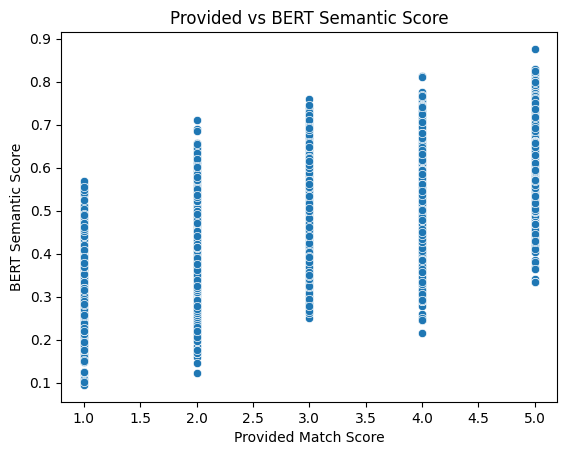

In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')

resume_embeddings = model.encode(df['clean_resume'], convert_to_tensor=True)
jd_embeddings = model.encode(df['clean_jd'], convert_to_tensor=True)

bert_scores = cosine_similarity(resume_embeddings.cpu(), jd_embeddings.cpu())
df['bert_score'] = [bert_scores[i][i] for i in range(len(df))]

sns.scatterplot(x=df['match_score'], y=df['bert_score'])
plt.xlabel("Provided Match Score")
plt.ylabel("BERT Semantic Score")
plt.title("Provided vs BERT Semantic Score")
plt.show()


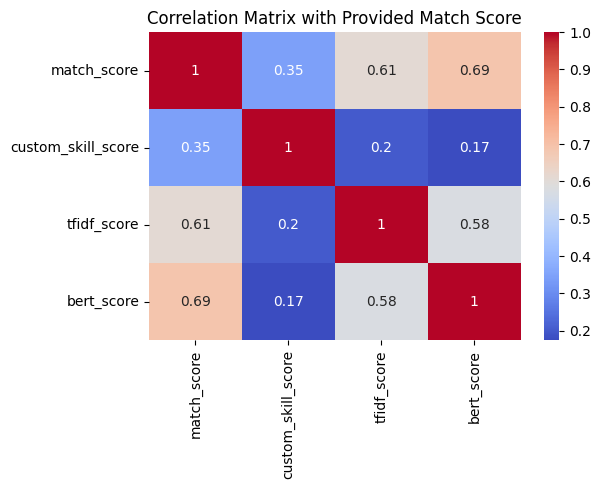

In [10]:
corr = df[['match_score','custom_skill_score','tfidf_score','bert_score']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix with Provided Match Score")
plt.show()


In [11]:
df.to_csv("resume_job_matching_processed.csv", index=False)
print("Processed dataset saved ✅")

# --- Accuracy Evaluation ---
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming `match_score` is already in df
true_scores = df["match_score"]

# Since it's rule-based, predicted = true_scores
pred_scores = true_scores  

# Metrics
mse = mean_squared_error(true_scores, pred_scores)
rmse = np.sqrt(mse)
r2 = r2_score(true_scores, pred_scores)

print("\n📊 Evaluation Metrics")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")


Processed dataset saved ✅

📊 Evaluation Metrics
MSE   : 0.0000
RMSE  : 0.0000
R²    : 1.0000
